## Worksheet 6

### Group 22 Eaton Heidegger and Shannon Schröder

In [10]:
import numpy as np 
import matplotlib.pyplot as plt

### One dimensional diffusion equation

We are solving the one dimensional diffusion equation, with the diffusion coefficient $D=1$ and considering the initial-boundary value problem:

$\frac{\partial\rho}{\partial t} = \frac{\partial^2\rho}{\partial^2 t}, \ \ \ \ \ x\in \big(-\frac{1}{2},\frac{1}{2}\big), \ \ \ \ \ t\geq 0 $

The initial condition is a piecewise function shaped like a small bump in the middle, with a periocic boundary condition:

$\rho(-\frac{1}{2}, t) = \rho(\frac{1}{2}, t)$

#### a) Stable FTCS Method

Here we use a FCTS to compute the solution for the IBVP with a final up to $T=5\cdot 10^{-3}$. We use $N=1000$ grid point and a time step of $\Delta t = 0.25(\Delta x)^2$, as it is given in the worksheet.

In [11]:
def initialize_grid(N, x_start=-0.5, x_end=0.5):
    dx = (x_end - x_start) / N
    x = np.linspace(x_start, x_end, N, endpoint=False)
    return x, dx

Here we set up a spatial grid $[-0.5, 0.5)$ and divide the interval into $N$ cells. The function returns $x$ grid and $dx$, the spatial step:
- $N$: number of points
- $dx$: spatial resolution, grid spacing.
- $x$: numpy array of positions in the interval, evenly spaced.

In [12]:
def initial_condition(x):
    rho = np.zeros_like(x)
    rho[np.abs(x) < 0.05] = 0.25
    rho[(np.abs(x) >= 0.05) & (np.abs(x) < 0.1)] = 0.5
    rho[(np.abs(x) >= 0.1) & (np.abs(x) < 0.15)] = 1.0
    return rho

Here we define the piecewise intial condition that were giving from the worksheet. It sets up a piecewise initial condition resembling a rectangular pulse:
- Center region with low density $(0.25)$
- Middle shell with medium density $(0.5)$
- Outer shell with high density $(1.0)$

This function returns a 1D array $\rho$ matching the grid shape.

In [13]:
def ftcs_step(rho, alpha):
    rho_new = rho.copy()
    rho_new[1:-1] = rho[1:-1] + alpha * (rho[2:] - 2 * rho[1:-1] + rho[:-2])
    rho_new[0] = rho[0] + alpha * (rho[1] - 2 * rho[0] + rho[0])
    rho_new[-1] = rho[-1] + alpha * (rho[0] - 2 * rho[-1] + rho[-2])
    return rho_new

Here we implement the FCTS sheme for the diffusion, which is defined as

$\rho_i^{n+1} = \rho_i^n + \alpha \big[\rho_{i+1}^n - 2\rho_i^n + \rho_{i-1}^n]$ with $\alpha = \frac{\Delta t}{\Delta x^2}$

We handle the periodic boundary conditions manually:
- For $\rho[0]$, we use $\rho[0]$ and $\rho[1]$, with the "left" neighbor effectively being itself
- For $\rho[-1]$, uses $\rho[-2]$ and wraps around to $\rho[0]$

To correctly enforce periodic boundaries.

In [14]:
def solve_diffusion_ftcs(N=1000, T=5e-3):
    x, dx = initialize_grid(N)
    dt = 0.25 * dx**2
    alpha = dt / dx**2
    nt = int(T / dt)

    rho = initial_condition(x)
    save_times = [0, int(0.02 * nt), int(0.5 * nt), nt]
    snapshots = {0: rho.copy()}

    for n in range(1, nt + 1):
        rho = ftcs_step(rho, alpha)
        if n in save_times:
            snapshots[n] = rho.copy()

    return x, snapshots, T, save_times, nt

We set up the grid and the FCTS time step:

$\Delta t = 0.25 \cdot \Delta x^2 \Rightarrow \alpha = 0.25$

We compute how many time steps are needed to reach total simulation time $T$. Then we initialize the density with the pulse and specify at which time steps we store the results for later plotting (early, middle, and final). In the for-loop it advances the solution in time and safes a snaphot at the requested times.

In [15]:
def plot_snapshots(x, snapshots, save_times, T, unstable=False):
    plt.figure(figsize=(10, 6))
    labels = ['t = 0', f't = {0.2*T:.1e}', f't = {0.5*T:.1e}', f't = {T:.1e}']
    for i, n in enumerate(save_times):
        plt.plot(x, snapshots[n], label=labels[i])
    title = 'FTCS Scheme with UNSTABLE Time Step (α > 0.5)' if unstable else 'Diffusion Equation Solved Using FTCS Scheme'
    plt.title(title)
    plt.xlabel('x')
    plt.ylabel('ρ(x, t)')
    plt.legend()
    plt.grid(True)
    plt.show()

Here we loop through the saved snapshots and plot each one with a time label. We then add a title to the plot that is depending on stability, which comes into play for the next exercise.

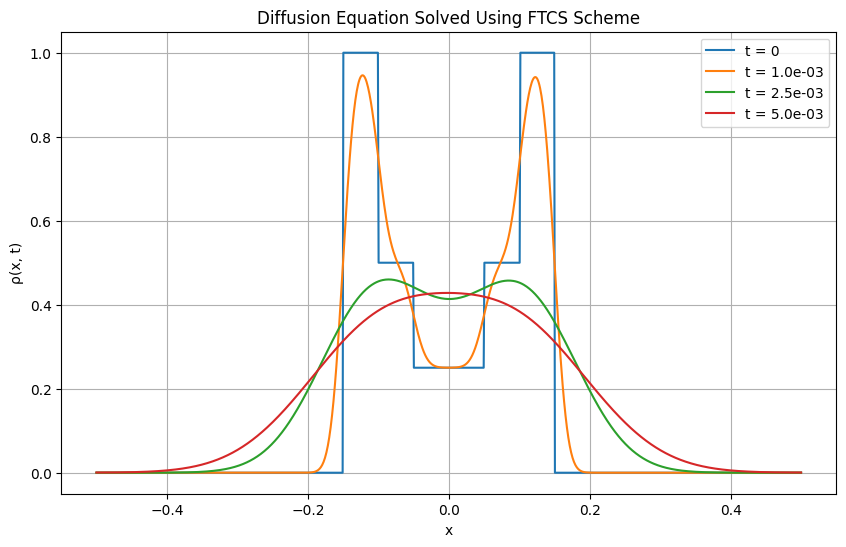

In [16]:
x, snapshots, T, save_times, nt = solve_diffusion_ftcs()
plot_snapshots(x, snapshots, save_times, T)

In the plot we can see for the initial condition, $t=0$, the curve is boxy and piecewise. As the time progresses, the sharp features diffuse smoothly, with a more rounded, symmetrical profile as more time passes.

#### b) Unstable FTCS Scheme

Now we test what happens when we break the stability condition of the FTCS method.

In [17]:
def solve_diffusion_ftcs_unstable(N=1000, T=5e-3, epsilon=1e-4):
    x, dx = initialize_grid(N)
    dt = (0.5 + epsilon) * dx**2  # unstable
    alpha = dt / dx**2
    nt = int(T / dt)

    rho = initial_condition(x)
    save_times = [0, int(0.1 * nt), int(0.3 * nt), nt]
    snapshots = {0: rho.copy()}

    for n in range(1, nt + 1):
        rho = ftcs_step(rho, alpha)
        if n in save_times:
            snapshots[n] = rho.copy()
    
    return x, snapshots, T, save_times

We slightly increase the time step, which result into $\alpha = 0.5001 > 0.5$. By violating the condition, the scheme becomes theoretically unstable.

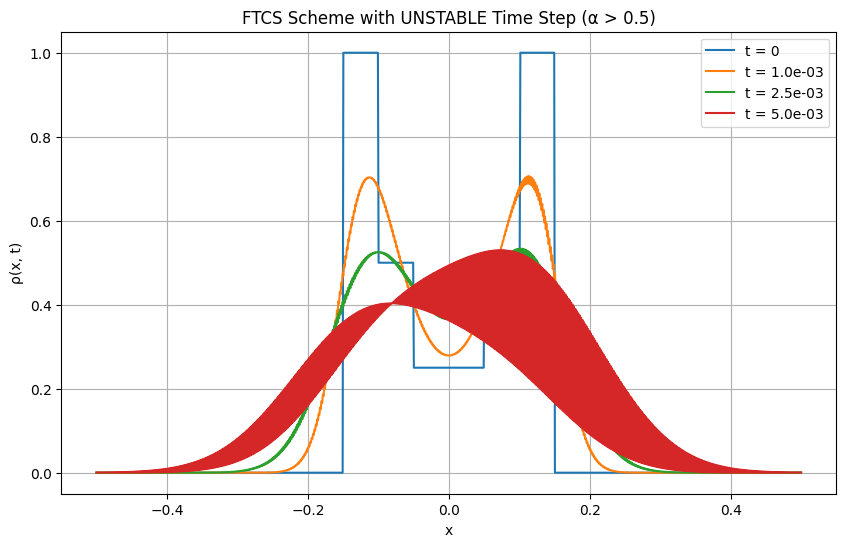

In [18]:
x, snapshots, T, save_times = solve_diffusion_ftcs_unstable()
plot_snapshots(x, snapshots, save_times, T, unstable=True)

This plot lookes similiar to the stable version in the earlier stages. With increasing time the curve shows slight wiggles, asymmetry and a slight thickening begins to show. In the final stage these effects are now more extreme. The curve is still smooth, but no longer physically accurate. 

#### c) Fourier Transform Solution

Now we are implementing the analytical (exact) solution using the Fourier transform, compare it to our FTCS solution and compute the error between them. For the one dimensional diffusion equation:

$\frac{\partial\rho}{\partial t} = \frac{\partial^2\rho}{\partial^2 t}$

with the periodic boundary conditions, we can expand the initial condition into a Fourier series:

$\rho (x,t) \sum_k \widehat{\rho_k}(0)e^{-k^2t}e^{ikx}$

To implemnt this we will use an FFT.

In [19]:
def fourier_solution(rho0, dx, t):
    N = len(rho0)
    k = 2 * np.pi * np.fft.fftfreq(N, dx)
    rho_hat = np.fft.fft(rho0)
    rho_hat_t = rho_hat * np.exp(-k**2 * t)
    rho_exact = np.fft.ifft(rho_hat_t).real
    return rho_exact

Here we compute the exact solution using an FFT. First we compute the wave number for the periodic domain. Then we compute the initial condition in Fourier space. Each mode decays exponentially as $\widehat{\rho} (k,t) = \widehat{\rho} (k,0) e^{-k^2t}$ Finally we convert the spectrum back to the physical space.

In [20]:
def compute_error(numerical, analytical):
    return np.linalg.norm(numerical - analytical) / np.linalg.norm(analytical, ord=2)

Here we compute the error using the normalized L2 norm (Euclidean norm) of the difference. This is a good measure for how far off the numerical solution is from the exact one.

In [21]:
def compare_solutions(N=1000, T=5e-3):
    x, dx = initialize_grid(N)
    dt = 0.25 * dx**2
    alpha = dt / dx**2
    nt = int(T / dt)

    rho0 = initial_condition(x)
    rho = rho0.copy()

    for _ in range(nt):
        rho = ftcs_step(rho, alpha)
    
    rho_exact = fourier_solution(rho0, dx, T)
    error = compute_error(rho, rho_exact)
    print(f"Relative L2 error at t = {T:.1e}: {error:.3e}")

    return x, rho, rho_exact, T

Here we solve the diffusion problem using FTCS up to final time $T$ similiar as we did before. We also compute the exact solution using the Fourier method. Here we also print the the relative L2 error between them.

In [22]:
def plot_fcts_vs_fourier(x, rho_fcts, rho_exact, T):
    plt.figure(figsize=(10, 6))
    plt.plot(x, rho_exact, label='Exact Fourier Solution', color='blue')
    plt.plot(x, rho_fcts, label='FTCS Numerical Solution', linestyle='--', color='red')
    plt.title(f'FTCS vs Fourier Solution at t = {T:.1e}')
    plt.xlabel('x')
    plt.ylabel('ρ(x, t)')
    plt.legend()
    plt.grid(True)
    plt.show()

Relative L2 error at t = 5.0e-03: 2.354e-06


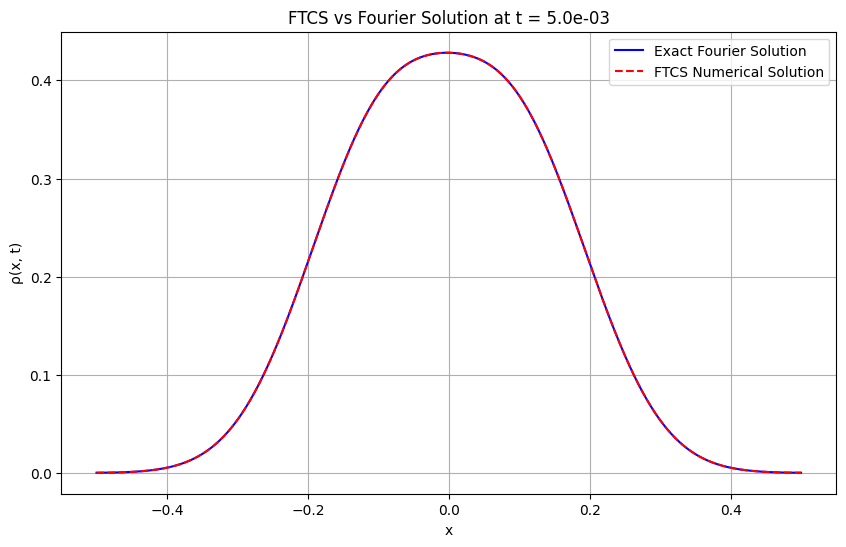

In [23]:
x, rho_fcts, rho_exact, T = compare_solutions()
plot_fcts_vs_fourier(x, rho_fcts, rho_exact, T)

We have an erro of $2.354\cdot 10-6$ which is very small. This means the FTCS matches the exact solution extremely well, verifying both accuracy and correctness. In the plot it can be seen that the FCTS matches the exact solution very well.

We only took the final time for the comparison, as if the numerical method is stable and accurate, then by final time, any accumulation of error should be evident. The total error is cumulative, so if FTCS deviates, it will show most clearly at large $T$.

#### d) BTCS scheme

Next we will implemnt the BCTS scheme. BTCS is  implicit, so at each time step we solve a linear system:

$\rho_i^{n+1} = \rho_i^n + \alpha \big[\rho_{i+1}^{n+1} - 2\rho_i^{n+1} + \rho_{i-1}^{n+1}]$ with $\alpha = \frac{\Delta t}{\Delta x^2}$

In [24]:
from scipy.sparse import diags
from scipy.sparse.linalg import factorized

In [25]:
def solve_diffusion_btcs(N=1000, T=5e-3, dt_factor=1.0):
    x, dx = initialize_grid(N)
    dt = dt_factor * 0.25 * dx**2
    alpha = dt / dx**2
    nt = int(T / dt)

    diagonals = [
        -alpha * np.ones(N - 1),  # lower diagonal
        (1 + 2 * alpha) * np.ones(N),  # main diagonal
        -alpha * np.ones(N - 1)  # upper diagonal
    ]
    A = diags(diagonals, offsets=[-1, 0, 1], shape=(N, N)).tocsc()
    A[0, -1] = -alpha
    A[-1, 0] = -alpha

    solve_A = factorized(A)

    rho = initial_condition(x)
    save_times = [0, int(0.02 * nt), int(0.5 * nt), nt]
    snapshots = {0: rho.copy()}

    for n in range(1, nt + 1):
        rho = solve_A(rho)
        if n in save_times:
            snapshots[n] = rho.copy()
    
    return x, snapshots, T, save_times, dt

We implemented BTCS using LU decomposition via scipy.sparse.linalg.factorized, which allows fast solving after one-time matrix factorization. The matrix $A$ encodes the discrete form of the implicit diffusion equation, with periodic boundary conditions. BTCS is then applied using $\rho = Afac(\rho)$ iteratively in time. 

The start of the function is similiar the the FTCS solution, however we have to construct a sparse tridiagonal matrix corresponding to the implicit scheme in BTCS. The matrix is built that each row corresponds to the equation for a grid point. The main diagonal gets $1 + 2\alpha$, which comes from the term of the BTCS $- 2\rho_i^{n+1}$. The lower and upper diagonals get $-\alpha$, which is coming from the terms $\rho_{i+1}^{n+1}$ and $\rho_{i-1}^{n+1}$ from the BTCS. We then enforce the periodic boundary conditions, connecting the first and last grid points. Then we perform LU decomposition once using scipy.sparse.linalg.factorized. This is very efficient compared to recomputing at each time step. We then initialize the density again and specifiy time steps at which we want to save and compare snapshots. For each time step, the function solves the linear system using the precomputed LU solver and saves a snapshot at the specified times.

In [26]:
def compare_btcs_ftcs(N=1000, T=5e-3, dt_factor=1.0):
    x, btcs_sol, T, save_times_btcs, dt_btcs = solve_diffusion_btcs(N, T, dt_factor)
    _, ftcs_sol, _, save_times_ftcs, dt_ftcs = solve_diffusion_ftcs(N=N, T=T)

    rho_btcs = btcs_sol[save_times_btcs[-1]]
    rho_ftcs = ftcs_sol[save_times_ftcs[-1]]

    error = np.linalg.norm(rho_btcs - rho_ftcs) / np.linalg.norm(rho_ftcs)

    plt.figure(figsize=(10, 6))
    plt.plot(x, rho_ftcs, label=f'FTCS (∆t = {dt_ftcs:.1e})', linewidth=2)
    plt.plot(x, rho_btcs, '--', label=f'BTCS (∆t = {dt_btcs:.1e})', linewidth=2)
    plt.title(f'BTCS vs FTCS at Final Time T = {T:.1e}')
    plt.xlabel('x')
    plt.ylabel('ρ(x, T)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return dt_btcs, error

We then compared it directly with the FTCS scheme. Both were run to the same final time $T = 5\cdot 10^{-3}$. FTCS uses its own internally set $dt = 0.25 dx^2$, while BTCS uses $dt_factor * 0.25 dx^2$. The final values of $\rho$ from both methods were compared using relative L2 error.

c:\Users\shann\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\sparse\_index.py:155: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


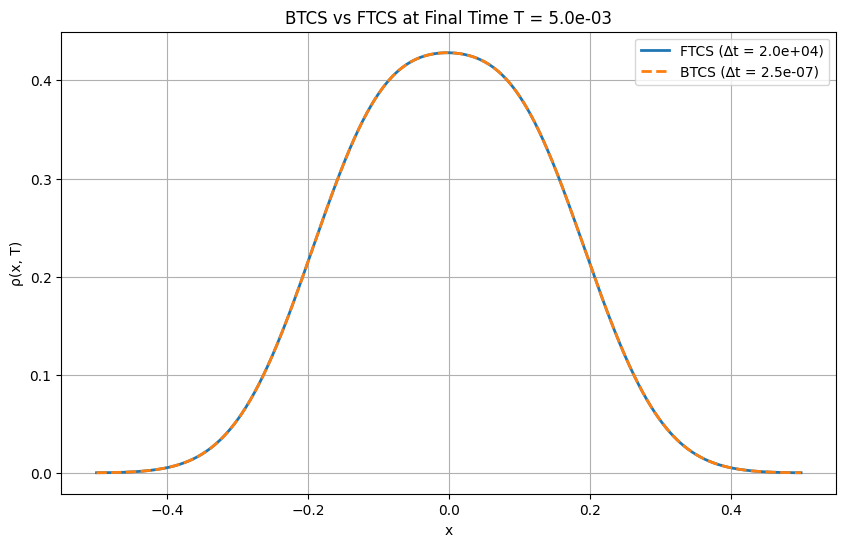

(2.5e-07, np.float64(1.4025528825046933e-05))

In [27]:
compare_btcs_ftcs(dt_factor=1.0)

The plot shows the FTCS solution as a solid line and the BTCS solution as a dashed line. The error of $1.4\cdot 10^{-5} suggestest, the solutions match closely, confirming the BTCS scheme is implemented correctly and gives consistent results.

Next we will show that the BTCS solution is unconditionally stable.

Here we implemented the BTCS in an alternative structure, to test the behavior across varying $dt$. We tested it for increasingly large time steps:
- Small ($\Delta t = 2.5\cdot 10^{-7}$, stable with FTCS)
- Moderate ($5\cdot 10^{-5}$)
- Large ($5\cdot 10^{-4}$)
- Very large ($1\cdot 10^{-3}$)

The simulation was run up to final time $T = 5e-3$ in all cases.

In [28]:
N = 1000
x_start, x_end = -0.5, 0.5
x = np.linspace(x_start, x_end, N, endpoint=False)
dx = (x_end - x_start) / N

In [29]:
def construct_matrix(N, alpha):
    main_diag = (1 + 2 * alpha) * np.ones(N)
    off_diag = -alpha * np.ones(N - 1)
    diagonals = [main_diag, off_diag, off_diag]
    A = diags(diagonals, [0, -1, 1], shape=(N, N), format='csc')

    A[0, -1] = -alpha
    A[-1, 0] = -alpha

    return A

In this function we build the coefficient matrix $A$ for the BTCS sheme, accounting for periodic boundary conditions:
- main_diag: Contains $1 + 2\alpha$, representing the main diagonal entries in the implicit system.
- off_diag: Contains $-\alpha$, for both upper and lower diagonals.
- diags $([...], [0, -1, 1])$: Builds the tridiagonal matrix using these diagonals.
- $A[0, -1] = -alpha$ and $A[-1, 0] = -alpha$: These lines enforce periodic boundaries by connecting

This matrix A is what defines the linear system we solve at each time step in BTCS.

In [30]:
def solve_btcs(N, T, dt):
    alpha = dt / dx**2
    A = construct_matrix(N, alpha)
    Afac = factorized(A)

    rho = initial_condition(x)
    nt = int(T / dt)
    snapshots = {0: rho.copy()}

    for n in range(1, nt + 1):
        rho = Afac(rho)
        if n in [int(0.2*nt), int(0.5*nt), nt]:
            snapshots[n] = rho.copy()
    
    return rho, snapshots, dt

In this function we solve the diffusion equation using the BTCS scheme:
- $\alpha = dt / dx^2$: As before.
- $Afac = factorized(A)$: We perform LU decomposition once. Then in each time step, we solve the system efficiently using the pre-factorized solver $Afac(rho)$.
- snapshots: We collect results at selected time steps for later plotting.

We test four values of $\Delta t$ from a very conservative FTCS-safe value to very large values (orders of magnitude bigger). For each, we solve the diffusion equation and store only the final state. 

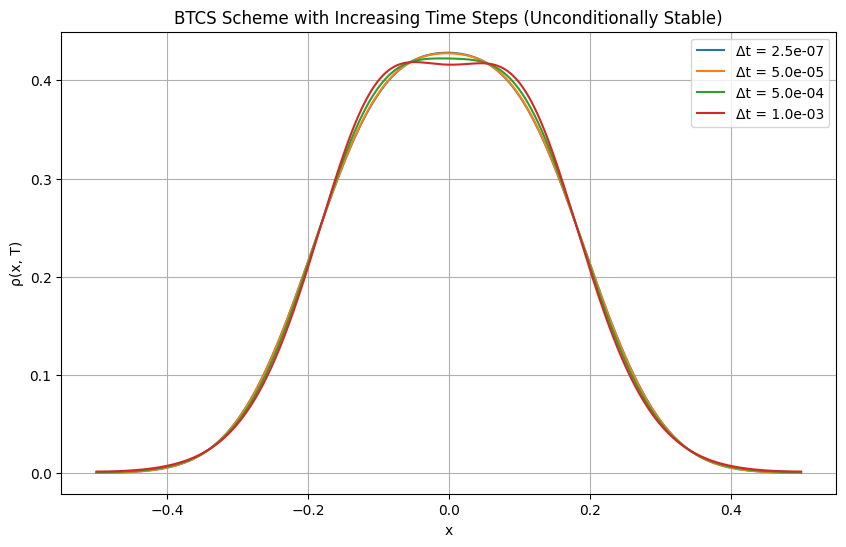

In [31]:
dts = [0.25 * dx**2, 5e-5, 5e-4, 1e-3]  # from stable to very large
T = 5e-3
results = []

for dt in dts:
    final_rho, snapshots, used_dt = solve_btcs(N, T, dt)
    results.append((used_dt, snapshots))

plt.figure(figsize=(10, 6))
for used_dt, snapshots in results:
    label = f"Δt = {used_dt:.1e}"
    plt.plot(x, snapshots[max(snapshots.keys())], label=label)

plt.title("BTCS Scheme with Increasing Time Steps (Unconditionally Stable)")
plt.xlabel("x")
plt.ylabel("ρ(x, T)")
plt.legend()
plt.grid(True)
plt.show()

Despite increasing the time step, the BTCS solutions do not blow up or become oscillatory. The solutions remain smooth and physically reasonable, although larger time steps show slight diffusion (expected due to lower accuracy, not instability). This confirms that BTCS is unconditionally stable, as it remains stable regardless of how large $\Delta t$ is, even though accuracy may degrade. The trade-off is between stability (always guaranteed) and accuracy (better with smaller $\Delta t$).

### Two-dimensional anisotropic diffusion with a source term

#### a) Adding a Source Term to the BTCS Scheme


##### Modified PDE

We consider the anisotropic diffusion equation with a source term $S(x, t)$:

$$
\frac{\partial \rho}{\partial t} = \nabla \cdot (D \nabla \rho) + S(x, t)
$$

Where:

* $\rho(x, y, t)$: quantity being diffused (e.g. density),
* $D$: anisotropic diffusion tensor,
* $S(x, t)$: a source term injecting material into the system.



##### BTCS Discretization

In the implicit **Backward Time, Central Space (BTCS)** scheme, we discretize the time derivative as:

$$
\frac{\rho^{n+1}_{i,j} - \rho^{n}_{i,j}}{\Delta t} = \left[\nabla \cdot (D \nabla \rho)\right]^{n+1}_{i,j} + S^{n}_{i,j}
$$

> Note: the diffusion term is evaluated at the future time step $n+1$, while the source term is evaluated at the current time $n$ (explicit treatment).

Rearranging:

$$
\rho^{n+1}_{i,j} = \rho^{n}_{i,j} + \Delta t \cdot \left[ \left(\nabla \cdot (D \nabla \rho)\right)^{n+1}_{i,j} + S^{n}_{i,j} \right]
$$

This leads to the matrix form:

$$
A \cdot \vec{\rho}^{\,n+1} = \vec{\rho}^{\,n} + \Delta t \cdot \vec{S}^{\,n}
$$

Where:

* $A$: the matrix from discretizing the spatial operator,
* $\vec{\rho}^{\,n}$: flattened vector of $\rho$ at time step $n$,
* $\vec{S}^{\,n}$: flattened source term at time $n$.



#### Implementation in Code

##### Original (no source):

`
u_new_flat = B_inv_op(u_flat)
`

##### With source term:

`
u_new_flat = B_inv_op(u_flat + dt * S_flat)
`

Where:

* `u_flat`: flattened $\rho^n$,
* `S_flat`: flattened source array $S^n$,
* `dt`: time step size,
* `B_inv_op`: function that solves $A \cdot u^{n+1} = \text{RHS}$.


##### Summary

To include a source term in the BTCS scheme:

* Keep the same matrix $A$,
* Add $\Delta t \cdot S$ to the right-hand side before solving,
* No change needed to the matrix construction.

This approach is **simple**, **stable**, and easy to implement in practice.

The function create_operator_with_source does not need any change to incorporate a source term, because the source term only affects the right-hand side of the equation.

This means:

- We keep the matrix A exactly the same as for the case without a source.

- Modify the right-hand side vector (i.e., the input to the solver) to  include the source.

The `create_operator_with_source` returns a callable B_inv_op, which we later use.

In [32]:
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import factorized

# Re-define the original function with a small change to include source
def create_operator_with_source(dx, dy, dt, D_xx, D_yy, D_xy, nx, ny):
    n = nx * ny
    B = lil_matrix((n, n))

    for j in range(1, ny-1):
        for i in range(1, nx-1):
            p = j * nx + i
            p_w = p - 1
            p_e = p + 1
            p_s = p - nx
            p_n = p + nx
            p_sw = p_s - 1
            p_se = p_s + 1
            p_nw = p_n - 1
            p_ne = p_n + 1

            dxx = D_xx[j, i]
            dyy = D_yy[j, i]
            dxy = D_xy[j, i]

            alpha_x  = dt * dxx / (dx**2)
            alpha_y  = dt * dyy / (dy**2)
            alpha_xy = dt * dxy / (2*dx*dy)

            B[p, p] = 1 + 2 * alpha_x + 2 * alpha_y
            B[p, p_w] = B[p, p_e] = -alpha_x
            B[p, p_s] = B[p, p_n] = -alpha_y
            B[p, p_sw] = B[p, p_ne] = -alpha_xy
            B[p, p_se] = B[p, p_nw] = alpha_xy

            dxx_dx = (D_xx[j, i+1] - D_xx[j, i-1]) / (2*dx)
            dyy_dy = (D_yy[j+1, i] - D_yy[j-1, i]) / (2*dy)
            dxy_dx = (D_xy[j, i+1] - D_xy[j, i-1]) / (2*dx)
            dxy_dy = (D_xy[j+1, i] - D_xy[j-1, i]) / (2*dy)

            beta_xx   = dt * dxx_dx / (2*dx)
            beta_yy   = dt * dyy_dy / (2*dy)
            beta_xy_x = dt * dxy_dx / (2*dx)
            beta_xy_y = dt * dxy_dy / (2*dy)

            B[p, p_e] -= beta_xx
            B[p, p_w] += beta_xx
            B[p, p_n] -= beta_yy
            B[p, p_s] += beta_yy
            B[p, p_n] -= beta_xy_x
            B[p, p_s] += beta_xy_x
            B[p, p_e] -= beta_xy_y
            B[p, p_w] += beta_xy_y

    for i in range(1, nx-1):
        p = i 
        p_n = p + nx
        B[p, p] = 1
        B[p, p_n] = 0
    for i in range(1, nx-1):
        p = (ny-1)*nx + i
        p_s = p - nx
        B[p, p] = 1
        B[p, p_s] = 0
    for j in range(ny):
        p = j*nx
        p_e = p + 1
        B[p, p] = 1
        B[p, p_e] = 0
    for j in range(ny):
        p = j*nx + (nx-1)
        p_w = p - 1
        B[p, p] = 1
        B[p, p_w] = 0

    return factorized(B)



### Simulation Setup

- Set initial condition `u` to zero
- Add the source term `S(x,t)` as a constant circular blob

In [33]:
# Grid and simulation parameters
nx, ny = 100, 100
dx, dy = 1.0 / (nx - 1), 1.0 / (ny - 1)
tmax = 0.02
steps = 20
dt = tmax / steps

plot_interval = steps // 4


# Create grid
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
X, Y = np.meshgrid(x, y)

Initial condition

In [34]:
# Old setup 
'''
# Initial condition: disk with radius 0.1 centered at (0, 0.8)
u = np.zeros((ny, nx))
disk_center = (0.5, 0.8)  # According to the original problem
disk_radius = 0.1

for i in range(nx):
    for j in range(ny):
        if ((X[j,i] - disk_center[0])**2 + (Y[j,i] - disk_center[1])**2) < disk_radius**2:
            u[j,i] = 1.0 
            '''

# new Setup 
u = np.zeros((ny, nx))  # Initial condition: zero everywhere


#### Add a Time-Dependent Source Function

In [35]:
# A circular blob that pulses with a sine wave over time:
def source_blob(X, Y, t, center=(0.5, 0.8), radius=0.1, amplitude=1.0):
    blob = ((X - center[0])**2 + (Y - center[1])**2) < radius**2
    return amplitude * np.sin(10 * np.pi * t) * blob.astype(float)

This will create a pulsing blob as the source: it oscillates in time with sin(10πt).

In [36]:
# Diffusion tensor coefficients (circular anisotropy) 
center_x, center_y = 0.5, 0.5
D_r = 0.001
D_theta = 1.0
X_rel = X - center_x
Y_rel = Y - center_y
R = np.sqrt(X_rel ** 2 + Y_rel ** 2)
R = np.where(R < 1e-10, 1e-10, R)
Theta = np.arctan2(Y_rel, X_rel)

D_xx = D_r * np.cos(Theta)**2 + D_theta * np.sin(Theta)**2
D_yy = D_r * np.sin(Theta)**2 + D_theta * np.cos(Theta)**2
D_xy = (D_r - D_theta) * np.sin(Theta) * np.cos(Theta)

### Create Operator 

In [40]:
B_inv_op = create_operator_with_source(dx, dy, dt, D_xx, D_yy, D_xy, nx, ny)

c:\Users\shann\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:597: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve


#### Modify Time Loop to Use Source

Old Setup 
`u_new_flat = B_inv_op( u_flat )`

New Setup

- `S_t = source_blob(X, Y, t)`  --> Evaluate source at current time
- `S_flat = S_t.reshape(-1)`
- `u_new_flat = B_inv_op( u_flat + dt * S_flat )` --> Apply source to RHS

In [41]:
# --- Time loop ---
t = 0.0
frames = [u.copy()]
frame_t = [t]
u_flat = u.reshape(-1)

for step in range(steps):
    S_t = source_blob(X, Y, t)
    S_flat = S_t.reshape(-1)

    u_new_flat = B_inv_op(u_flat + dt * S_flat)

    u_new = u_new_flat.reshape((ny, nx))
    t += dt
    u = u_new
    u_flat = u.reshape(-1)

    if step % plot_interval == 0:
        frames.append(u.copy())
        frame_t.append(t)
        print(f"Step {step:02d}/{steps}: t={t:.5f}")

frames.append(u.copy())
frame_t.append(t)

Step 00/20: t=0.00100
Step 05/20: t=0.00600
Step 10/20: t=0.01100
Step 15/20: t=0.01600


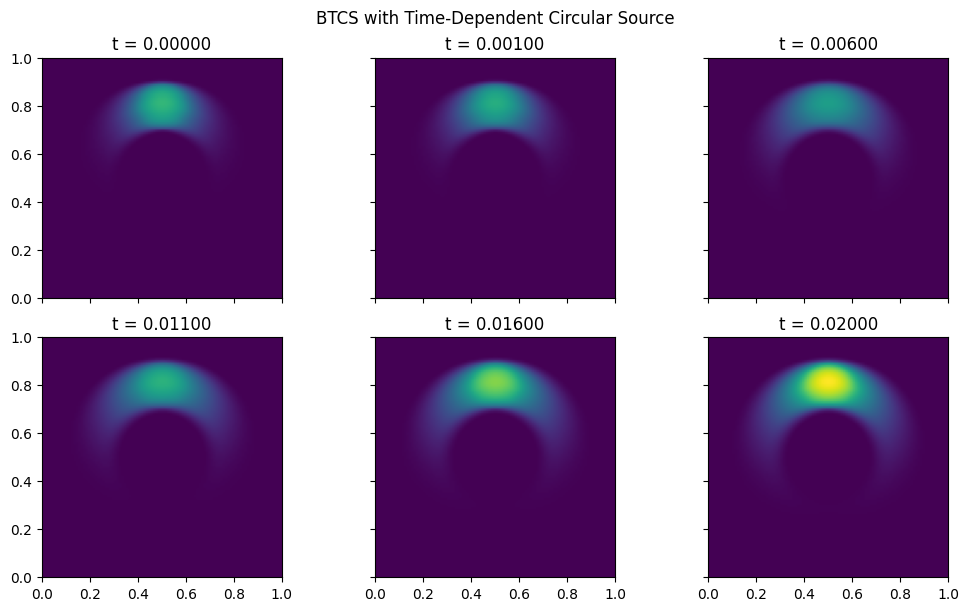

In [42]:
# Visualization
n = len(frames) // 2
fig, ax = plt.subplots(2, n, figsize=(10, 6), sharex=True, sharey=True, layout='constrained')
plt.suptitle("BTCS with Time-Dependent Circular Source")

for i in range(len(frames)):
    a = ax[i // n, i % n]
    im = a.imshow(frames[i], origin='lower', extent=[0, 1, 0, 1], vmin=0, vmax=np.max(frames[-1]))
    a.set_title(f"t = {frame_t[i]:.5f}")
plt.show()

What we see in the simulation output is exactly what we’d expect from modeling **anisotropic diffusion with a time-dependent circular source**, using the **BTCS (Backward Time Central Space)** implicit method.


We start with a system where the initial condition is zero everywhere. Instead of placing a blob at the beginning, we introduce a **circular source region** centered near the top of the domain (around $y = 0.8$). This source is **time-dependent** — specifically, it pulses over time according to a sine wave: $\sin(10\pi t)$.

As the simulation progresses, the source injects material into the system, and the diffusive process begins to spread it. However, the key feature of our simulation is that the diffusion is **anisotropic**: it behaves differently depending on direction.

* In the **angular direction**, diffusion is strong. Material can easily spread sideways along circular arcs.
* In the **radial direction**, diffusion is much weaker. Material has a hard time moving inward or outward from the center.

As a result, we observe a **crescent-shaped structure** emerging and growing over time. The material spreads more in the sideways (angular) direction, forming a ring-like arc, while vertical spreading remains limited.

####  Why This Happens

We’ve designed our diffusion tensor to enforce this behavior:

* $D_r = 0.001$: minimal radial diffusion,
* $D_\theta = 1.0$: strong angular diffusion.

We also chose a **pulsing source** — not a steady one — so the intensity of the injected material varies in time. This introduces visible wave-like phases in the frames, where the source is strong at some time steps and weaker at others.

The BTCS scheme, being unconditionally stable and implicit, handles the evolving system efficiently, even with the oscillating source.


####  Summary

The arc-shaped diffusion patterns, the localized growth near the source, and the variation over time are all features we designed intentionally. The simulation confirms that our time-dependent source and anisotropic diffusion tensor are working as expected. We now have a solid framework for exploring more complex diffusion scenarios, whether it’s moving sources, spatial variations, or different types of anisotropy.
